# Unsupervised Learning with Non-Ignorable Missing Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso as Lasso_Reg
from statsmodels.regression.linear_model import OLS
from sklearn.ensemble import RandomForestClassifier
import sklearn.preprocessing as Preprocessing
from sklearn.preprocessing import StandardScaler as Standardize
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from itertools import combinations
%matplotlib inline
####import math

/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
### create the different betas
    #########
    # If there are three latent variables, then each movie will have 3 sets of probability distributions
    # because there can be "teen, young adult, old people" categories that have different movie preferences.
    #
    # Input: z = 3, m = 3
    # Output: [ (z1:m1 rating),(z1:m2 rating), (z1:m3 rating), (z2:m1 rating), etc]
    #
    #########

def simulate_data(z=1, n = 100, m = 3, v = 5):
    all_beta = []
    for z_ in range(z):
        beta = []
        for m_ in range(m):
            beta_temp = np.random.dirichlet(np.ones(v),size=1)[0]
            beta.append(beta_temp)
        all_beta.append(beta)
        
#     theta = np.random.dirichlet(np.ones(z),size = 1)[0]
    # Generates which latent variable each user comes from    
    z_list = np.random.randint(1,z+1,n)
    complete_data = np.zeros((n,m))
    for i in range(len(z_list)):
        for m_ in range(m):
            complete_data[i][m_] = np.argmax(np.random.multinomial(1,list(all_beta[z_list[i]-1][m_])))+1
    return complete_data, all_beta,z_list

In [3]:
#### The EM algorithm based on the multinomial mixture model

def run_EM(theta,beta,phi,gamma,mu,lambda_,v,m,z,n,complete_data,r):
    import time

    start = time.time()
    
    ### store the past
    past_beta = np.zeros((v,m,z))
    past_gamma = np.zeros((m,z,n))
    past_phi = np.zeros((z,n))
    past_mu = np.zeros(v)
    past_lambda_ = np.zeros((v,m,z,n))
    past_theta = np.zeros(z)
    
    counter= 0
    
    eps = .01
    while(abs(past_beta-beta).sum() > eps and abs(past_gamma-gamma).sum() > eps and abs(past_mu-mu).sum() > eps and
         abs(past_phi-phi).sum() > eps and abs(past_lambda_-lambda_).sum() > eps and abs(past_theta-theta).sum() > eps): 
#     for i in range(100):    

        ### E step
        past_phi = np.copy(phi)
        past_lambda_ = np.copy(lambda_)
        past_theta = np.copy(theta)
        past_beta = np.copy(beta)
        past_gamma = np.copy(gamma)
        past_mu = np.copy(mu)
        ###### lambda
        for v_ in range(v):
            for m_ in range(m):
                for z_ in range(z):
                    for n_ in range(n):
                        lambda_[v_][m_][z_][n_] = ((complete_data[n_][m_]==(v_+1))*mu[v_]*beta[v_][m_][z_])**r[n_][m_]*((1-mu[v_])*beta[v_][m_][z_])**(1-r[n_][m_])


        ###### gamma
        gamma = lambda_.sum(axis = 0)

        ##### vectorized phi
        phi = np.tile(theta, (n,1)).T*gamma.prod(axis = 0)/(np.tile(theta, (n,1)).T*gamma.prod(axis = 0)).sum(axis=0)


        ### M step
        theta = phi.sum(axis=1)/phi.sum()

        #vectorized beta
        for v_ in range(v):
            for m_ in range(m):
                for z_ in range(z):
                    sum_ = 0
                    for n_ in range(n):
                        sum_ += phi[z_][n_]*lambda_[v_][m_][z_][n_]/gamma[m_][z_][n_]
                    beta[v_][m_][z_] = sum_

        beta = beta/phi.sum(axis=1)


        ######mu
        for v_ in range(v):
            num = 0
            denom = 0
            for n_ in range(n):
                for z_ in range(z):
                    for m_ in range(m):
                        num += phi[z_][n_]*r[n_][m_]*lambda_[v_][m_][z_][n_]/gamma[m_][z_][n_]
                        denom += phi[z_][n_]*lambda_[v_][m_][z_][n_]/gamma[m_][z_][n_]
            mu[v_] = num/denom

        if counter % 100 == 0:
            print counter
        counter += 1
    end = time.time()
    print(end - start)  
    return mu,gamma,phi,beta,theta,lambda_

In [4]:
#### Draws priors 

def create_prior(v,m,z,n):
    #mu
    mu = np.ones(v)
    for i in range(v):
        mu[i] = -.075*abs(i-2)+.5
    if z == 1:
        theta = [1]
    else:
        c = ()
        for i in range(z):
            c = (1,)+c
            
        theta = np.random.dirichlet(c,1).reshape((z,))
    c = ()
    for m_ in range(v):
        c = (1,) + c
    beta = np.random.dirichlet(c,(z,m)).transpose()
    
    phi = np.random.random((z,n))
    gamma = np.random.random((m,z,n))
    lambda_ = np.random.random((v,m,z,n))
    
    return mu,theta,beta,phi,gamma,lambda_


In [5]:
def calculate_missing(n,m,complete_data,mu):
    ####### R matrix that decides which values are missing
    r = np.ones((n,m))
    for n_ in range(n):
        for m_ in range(m):
            val = complete_data[n_][m_]
            if np.random.rand(1) < mu[val-1]:
                r[n_][m_] = 0
    return r
              

In [6]:
#### Uses converged beta, phi, and mu estimate to impute the missing values
def missing_value_filled_in(mu,phi,beta,n,m,missing_data,sample,replace = 0):
    
    ### fills in the data
    for n_ in range(n):
        for m_ in range(m):
            latent = np.argmax(phi[:,n_])
            if missing_data[n_][m_] == replace:
                temp = []
                for i in range(sample):
                    temp.append(np.argmax(np.random.multinomial(1, beta[:,m_,latent]))+1)
                missing_data[n_][m_] = np.mean(temp)
       
    return missing_data

In [7]:
#### uses mean to ipute missing values

def standard_imputation(missing_data):
    column_names = missing_data.columns
    for col in column_names:
        col_mean = np.mean(missing_data[col])
        for i in range(len(missing_data[col])):
            if missing_data[col][i] <= 0:
                missing_data[col][i] = col_mean
    print missing_data.shape
    return missing_data

# Single Sample Test Run

In [8]:
z=1
m = 5
v = 5
n = 1000
complete_data,true_beta,z_list = simulate_data(z = z,n=n,m=m)

In [9]:
mu,theta,beta,phi,gamma,lambda_ = create_prior(v,m,z,n)
r = calculate_missing(n,m,complete_data,mu)
missing_data = r*complete_data
target_var = complete_data[:,0]+complete_data[:,1] + complete_data[:,2]+complete_data[:,3]-complete_data[:,4]+np.random.normal(0,1,len(complete_data[:,0]))
mu,gamma,phi,beta,theta,lambda_ = run_EM(theta,beta,phi,gamma,mu,lambda_,v,m,z,n,complete_data*r,r)

/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0
34.3521771431


In [13]:
model_filled_in =  missing_value_filled_in(mu,phi,beta,n,m,np.copy(missing_data),10)

In [14]:
print beta
print true_beta

[[[ 0.18300617]
  [ 0.4339673 ]
  [ 0.06751667]
  [ 0.28983458]
  [ 0.337471  ]]

 [[ 0.36077439]
  [ 0.12228827]
  [ 0.17497751]
  [ 0.1307198 ]
  [ 0.05968037]]

 [[ 0.06304869]
  [ 0.30995299]
  [ 0.1438826 ]
  [ 0.06582196]
  [ 0.08006957]]

 [[ 0.21860876]
  [ 0.08558566]
  [ 0.36828079]
  [ 0.07291255]
  [ 0.07189868]]

 [[ 0.17456199]
  [ 0.04820579]
  [ 0.24534243]
  [ 0.44071111]
  [ 0.45088039]]]
[[array([ 0.18766259,  0.31580255,  0.08021955,  0.22606987,  0.19024545]), array([ 0.43458529,  0.10340175,  0.31712684,  0.09004635,  0.05483977]), array([ 0.07461902,  0.15144139,  0.14007485,  0.39676856,  0.23709619]), array([ 0.27588148,  0.15239013,  0.04899724,  0.08886259,  0.43386857]), array([ 0.33101636,  0.06171344,  0.08910238,  0.07754361,  0.44062421])]]


The betas look like they converge! Lets look at the performance against standard imputation

In [15]:
standard_missing_data = standard_imputation(pd.DataFrame(np.copy(missing_data)))
standard_model = Lasso_Reg(alpha = 0)
standard_model.fit(np.array(standard_missing_data),target_var)
print standard_model.score(np.array(standard_missing_data),target_var)

(1000, 5)
0.510464835369


/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  app.launch_new_instance()


In [16]:
fancy_model = Lasso_Reg(alpha = 0)
fancy_model.fit(np.array(model_filled_in),target_var)
print fancy_model.score(np.array(model_filled_in),target_var)

0.564436553188


/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  from ipykernel import kernelapp as app


In [17]:
complete_model = Lasso_Reg(alpha = 0)
complete_model.fit(np.array(complete_data),target_var)
print complete_model.score(np.array(complete_data),target_var)

0.916154219474


/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  from ipykernel import kernelapp as app


In [99]:
synthetic_stand_score = []
synthetic_model_score = []
for i in range(5):
    z=1
    m = 5
    v = 5
    n = 1000
    complete_data,true_beta,z_list = simulate_data(z = z,n=n,m=m)
    mu,theta,beta,phi,gamma,lambda_ = create_prior(v,m,z,n)
    r = calculate_missing(n,m,complete_data,mu)
    missing_data = r*complete_data
    target_var = complete_data[:,0]+complete_data[:,1] + complete_data[:,2]+complete_data[:,3]-complete_data[:,4]+np.random.normal(0,1,len(complete_data[:,0]))
    mu,gamma,phi,beta,theta,lambda_ = run_EM(theta,beta,phi,gamma,mu,lambda_,v,m,z,n,complete_data*r,r)
    model_filled_in =  missing_value_filled_in(mu,phi,beta,n,m,np.copy(missing_data),10)
    standard_missing_data = standard_imputation(pd.DataFrame(np.copy(missing_data)))
    standard_model = Lasso_Reg(alpha = 0)
    standard_model.fit(np.array(standard_missing_data),target_var)
    synthetic_stand_score.append(standard_model.score(np.array(standard_missing_data),target_var))
    fancy_model = Lasso_Reg(alpha = 0)
    fancy_model.fit(np.array(model_filled_in),target_var)
    synthetic_model_score.append(fancy_model.score(np.array(model_filled_in),target_var))


/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0
38.5157818794
(1000, 5)


/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


0
35.9994771481
(1000, 5)
0
37.5070221424
(1000, 5)
0
41.1043181419
(1000, 5)
0
35.5295670033
(1000, 5)


In [100]:
print np.mean(synthetic_stand_score)
print np.mean(synthetic_model_score)

0.439987958186
0.546176685545


# Try out the Sample Method for tradeoff

In [16]:
n_sample = [1,5,10,15,20,30,40]
score = []
for n_ in n_sample:
    model_filled_in = missing_value_filled_in(mu,phi,beta,n,m,np.copy(missing_data),n_)
    
    lasso = Lasso_Reg(alpha = 0)
    lasso.fit(np.array(model_filled_in),target_var)
    score.append(lasso.score(np.array(model_filled_in),target_var))

/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


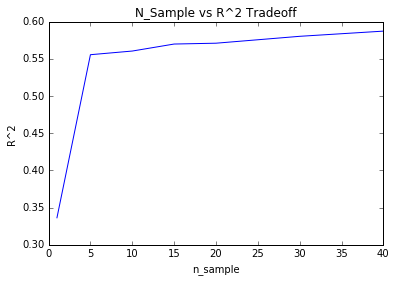

In [17]:
plt.plot(n_sample,score)
plt.ylabel('R^2')
plt.xlabel('n_sample')
plt.title('N_Sample vs R^2 Tradeoff')

# Multiple Latent Variable Testing

In [24]:
z_range = range(1,10)
rep = range(1,5)
latent_score = []
for z_ in z_range:
    for i in rep:
        z=z_
        m = 5
        v = 5
        n = 1000
        complete_data,true_beta,z_list = simulate_data(z = z,n=n,m=m)
        mu,theta,beta,phi,gamma,lambda_ = create_prior(v,m,z,n)
        r = calculate_missing(n,m,complete_data,mu)
        mu,gamma,phi,beta,theta,lambda_ = run_EM(theta,beta,phi,gamma,mu,lambda_,v,m,z,n,complete_data,r)
        missing_data = r*complete_data
        model_filled_in = missing_value_filled_in(mu,phi,beta,n,m,np.copy(missing_data),10)
        target_var = complete_data[:,0]+complete_data[:,1] + complete_data[:,2]+complete_data[:,3]-complete_data[:,4]+np.random.normal(0,1,len(complete_data[:,0]))

        
        standard_missing_data = standard_imputation(pd.DataFrame(np.copy(missing_data)))
        
        standard_model = Lasso_Reg(alpha = 0)
        standard_model.fit(np.array(standard_missing_data),target_var)
        standard_score =  standard_model.score(np.array(standard_missing_data),target_var)
        
        fancy_model = Lasso_Reg(alpha = 0)
        fancy_model.fit(np.array(model_filled_in),target_var)
        model_score =  fancy_model.score(np.array(model_filled_in),target_var)
        
        
        latent_score.append(model_score-standard_score)

/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0
30.4331889153
(1000, 5)


/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


0
32.9727928638
(1000, 5)
0
34.2378799915
(1000, 5)
0
31.115311861
(1000, 5)
0
66.9378809929
(1000, 5)
0
62.9908909798
(1000, 5)
0
70.5294280052
(1000, 5)
0
72.502407074
(1000, 5)
0
102.677103996
(1000, 5)
0
104.300826073
(1000, 5)
0
106.835358858
(1000, 5)
0
113.411142826
(1000, 5)
0
165.84483695
(1000, 5)
0
141.286710978
(1000, 5)
0
135.316684008
(1000, 5)
0
138.148699999
(1000, 5)
0
160.154866934
(1000, 5)
0
154.760251045
(1000, 5)
0
159.903769016
(1000, 5)
0
152.329175949
(1000, 5)
0
182.671153069
(1000, 5)
0
184.533655882
(1000, 5)
0
183.48898387
(1000, 5)
0
182.915058136
(1000, 5)
0
212.855450869
(1000, 5)
0
213.787418842
(1000, 5)
0
216.789247036
(1000, 5)
0
215.625316143
(1000, 5)
0
246.130751133
(1000, 5)
0
248.699056864
(1000, 5)
0
252.706894159
(1000, 5)
0
255.019356012
(1000, 5)
0
285.783178091
(1000, 5)
0
281.504235983
(1000, 5)
0
2118.55709219
(1000, 5)
0
673.287323952
(1000, 5)


In [31]:
z_1 = latent_score[0:4]
z_2 = latent_score[4:8]
z_3 = latent_score[8:12]
z_4 = latent_score[12:16]
z_5 = latent_score[16:20]
z_6 = latent_score[20:24]
z_7 = latent_score[24:28]
z_8 = latent_score[28:32]
z_9 = latent_score[32:36]


In [33]:
z_latent = [np.mean(z_1),np.mean(z_2),np.mean(z_3),np.mean(z_4),np.mean(z_5),np.mean(z_6),np.mean(z_7),np.mean(z_8),np.mean(z_9)]

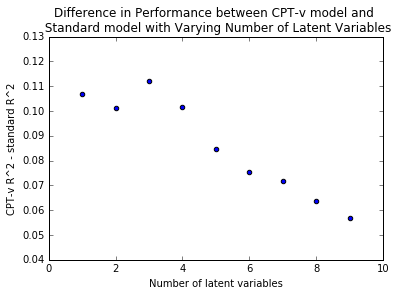

In [42]:
z_range = range(1,10)
plt.scatter(z_range,z_latent)
plt.xlabel('Number of latent variables')
plt.ylabel('CPT-v R^2 - standard R^2')
plt.title('Difference in Performance between CPT-v model and \n Standard model with Varying Number of Latent Variables')

# Different levels of missingness

In [48]:
np.random.uniform(.5,1,5)

array([ 0.59628043,  0.57178099,  0.99847098,  0.62941444,  0.83281527])

In [50]:
missingness = ['high','low','mid','normal']
rep = range(1,5)
missing_score = []
for m_ in missingness:
    for i in rep:
        z = 3
        m = 5
        v = 5
        n = 1000
        if m_ == 'high':
            mu_true = np.random.uniform(.5,1,v)
        elif m_ == 'low':
            mu_true = np.random.uniform(0,.5,v)
        elif m_ == 'normal':
            mu_true = np.random.rand(v)
        else:
            mu_true = np.random.uniform(.25,.75,v)
        
        complete_data,true_beta,z_list = simulate_data(z = z,n=n,m=m)
        mu,theta,beta,phi,gamma,lambda_ = create_prior(v,m,z,n)
        r = calculate_missing(n,m,complete_data,mu_true)
        mu,gamma,phi,beta,theta,lambda_ = run_EM(theta,beta,phi,gamma,mu,lambda_,v,m,z,n,complete_data,r)
        missing_data = r*complete_data
        model_filled_in = missing_value_filled_in(mu,phi,beta,n,m,np.copy(missing_data),10)
        target_var = complete_data[:,0]+complete_data[:,1] + complete_data[:,2]+complete_data[:,3]-complete_data[:,4]+np.random.normal(0,1,len(complete_data[:,0]))

        
        standard_missing_data = standard_imputation(pd.DataFrame(np.copy(missing_data)))
        
        standard_model = Lasso_Reg(alpha = 0)
        standard_model.fit(np.array(standard_missing_data),target_var)
        standard_score =  standard_model.score(np.array(standard_missing_data),target_var)
        
        fancy_model = Lasso_Reg(alpha = 0)
        fancy_model.fit(np.array(model_filled_in),target_var)
        model_score =  fancy_model.score(np.array(model_filled_in),target_var)
        
        
        missing_score.append(model_score-standard_score)

/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0
113.54144001
(1000, 5)


/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


0
105.512413025
(1000, 5)
0
103.632374048
(1000, 5)
0
95.7129790783
(1000, 5)
0
92.7498078346
(1000, 5)
0
99.4903430939
(1000, 5)
0
94.67969203
(1000, 5)
0
100.717151165
(1000, 5)
0
103.140543938
(1000, 5)
0
100.711321831
(1000, 5)
0
106.556642056
(1000, 5)
0
108.315388918
(1000, 5)
0
108.295706034
(1000, 5)
0
105.432034969
(1000, 5)
0
108.305302858
(1000, 5)
0
106.957323074
(1000, 5)


In [56]:
high = missing_score[0:4]
low = missing_score[4:8]
mid = missing_score[8:12]
normal = missing_score[12:16]
level_missing = [np.mean(low),np.mean(mid),np.mean(high),np.mean(normal)]

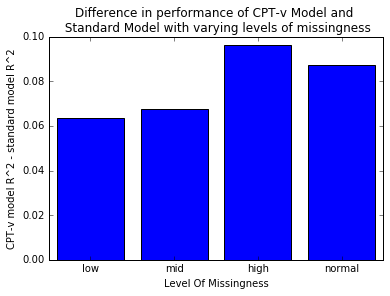

In [67]:
plt.bar(range(1,5),level_missing,align='center')
plt.xticks(range(1,5), ['low','mid','high','normal'])
plt.xlabel("Level Of Missingness")
plt.ylabel("CPT-v model R^2 - standard model R^2")
plt.title("Difference in performance of CPT-v Model and \n Standard Model with varying levels of missingness")

# Adding random noise performance

In [36]:
noise_range = [2,3,4,5]
rep = range(1,5)
model_avg_score = []
standard_avg_score = []
for noise in noise_range:
    model_score = []
    standard_score = []
    for i in rep:
        z = 3
        m = 5
        v = 5
        n = 1000
        
        complete_data,true_beta,z_list = simulate_data(z = z,n=n,m=m)
        mu,theta,beta,phi,gamma,lambda_ = create_prior(v,m,z,n)
        r = calculate_missing(n,m,complete_data,mu)
        mu,gamma,phi,beta,theta,lambda_ = run_EM(theta,beta,phi,gamma,mu,lambda_,v,m,z,n,complete_data,r)
        missing_data = r*complete_data
        missing_data = missing_data + np.random.randint(low = -noise, high = noise,size = (n,m))
        missing_data = r*missing_data
        missing_data[missing_data<0] = 1
        model_filled_in = missing_value_filled_in(mu,phi,beta,n,m,np.copy(missing_data),10)
        target_var = complete_data[:,0]+complete_data[:,1] + complete_data[:,2]+complete_data[:,3]-complete_data[:,4]+np.random.normal(0,1,len(complete_data[:,0]))

        
        standard_missing_data = standard_imputation(pd.DataFrame(np.copy(missing_data)))
        
        standard_model = Lasso_Reg(alpha = 0)
        standard_model.fit(np.array(standard_missing_data),target_var)
        standard_score.append(standard_model.score(np.array(standard_missing_data),target_var))
        
        fancy_model = Lasso_Reg(alpha = 0)
        fancy_model.fit(np.array(model_filled_in),target_var)
        model_score.append(fancy_model.score(np.array(model_filled_in),target_var))
        
    
    standard_avg_score.append(np.mean(standard_score))
    model_avg_score.append(np.mean(model_score))

/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0
116.37382102
(1000, 5)


/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/ChrsitineHwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


0
118.803184986
(1000, 5)
0
106.914715052
(1000, 5)
0
103.633102894
(1000, 5)
0
111.070809126
(1000, 5)
0
110.631963968
(1000, 5)
0
110.639685154
(1000, 5)
0
114.235594034
(1000, 5)
0
116.607471943
(1000, 5)
0
107.735539913
(1000, 5)
0
117.242504835
(1000, 5)
0
106.156084061
(1000, 5)
0
108.893769979
(1000, 5)
0
114.452344894
(1000, 5)
0
104.581709862
(1000, 5)
0
118.455373049
(1000, 5)


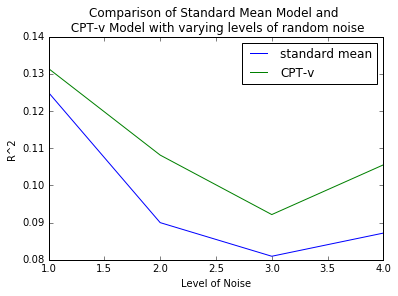

In [42]:
plt.plot(range(1,5),standard_score, label = 'standard mean')
plt.plot(range(1,5),model_score, label = 'CPT-v')
plt.legend()
plt.xlabel('Level of Noise')
plt.ylabel('R^2')
plt.title("Comparison of Standard Mean Model and \n CPT-v Model with varying levels of random noise")

In [47]:
np.array(model_score)-np.array(standard_score)

array([ 0.00644843,  0.0181553 ,  0.01120674,  0.01834211])

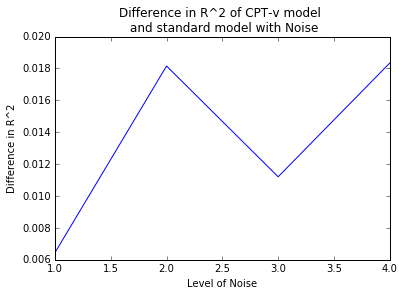

In [50]:
plt.plot(range(1,5), np.array(model_score)-np.array(standard_score))
plt.xlabel("Level of Noise")
plt.ylabel('Difference in R^2')
plt.title("Difference in R^2 of CPT-v model \n and standard model with Noise")

# Real Data Analysis

In [133]:
def fill_missing_data(missing_data,z=1):
    z=z
    m = 1
    v = int(missing_data.max())
    n = len(missing_data)
    
    missing_data = missing_data.reshape((n,m))
    mu_prior,theta_prior,beta_prior,phi_prior,gamma_prior,lambda_prior = create_prior(v,m,z,n)
    r = np.array([ 1-(x== -9) for x in missing_data]).reshape((n,m))
    mu,gamma,phi,beta,theta,lambda_ = run_EM(theta_prior,beta_prior,phi_prior,gamma_prior,mu_prior,lambda_prior,v,m,z,n,missing_data,r)
    model_filled_in = missing_value_filled_in(mu,phi,beta,n,m,np.copy(missing_data),10,replace=-9)
    return model_filled_in

In [134]:
import urllib
raw_data = urllib.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data")
dataset = np.loadtxt(raw_data,dtype = np.str_, delimiter=",")
dataset = pd.DataFrame(dataset)
dataset = dataset.replace('?','-9')
dataset = dataset.astype(float)

In [135]:
model_2 = fill_missing_data(dataset[2], z = 4)
model_3 = fill_missing_data(dataset[3], z = 4)
model_4 = fill_missing_data(dataset[4], z = 4)
# model_5 = fill_missing_data(dataset[5])

0
24.9853248596
0
28.1361000538
0
21.6643769741


In [136]:
dataset_fancy = np.copy(dataset)
dataset_fancy[:,2] = model_2.reshape((len(model_2),))
dataset_fancy[:,3] = model_3.reshape((len(model_3),))
dataset_fancy[:,4] =  model_4.reshape((len(model_4),))
dataset_fancy  = pd.DataFrame(dataset_fancy)

In [137]:
real_data_stand_score = []
real_data_model_score = []
for i in range(5):

    train_indices = np.random.uniform(size=len(dataset_fancy[0])) > 1. / 3.
    train = pd.DataFrame(dataset[train_indices])
    test = pd.DataFrame(dataset[~train_indices])
    col2_mean = np.mean(train[2][train[2]>=0])
    col3_mean = np.mean(train[3][train[3]>=0])
    col4_mean = np.mean(train[4][train[4]>=0])
    train[2] = train[2].replace(-9,col2_mean)
    train[3] = train[3].replace(-9,col3_mean)
    train[4] = train[4].replace(-9,col4_mean)


    col2_mean = np.mean(test[2][test[2]>=0])
    col3_mean = np.mean(test[3][test[3]>=0])
    col4_mean = np.mean(test[4][test[4]>=0])
    test[2] = test[2].replace(-9,col2_mean)
    test[3] = test[3].replace(-9,col3_mean)
    test[4] = test[4].replace(-9,col4_mean)

    standard = LogisticRegression()
    standard.fit(train[[0,1,2,3,4]],train[5])
    real_data_stand_score.append(standard.score(test[[0,1,2,3,4]],test[5]))
    
    train = dataset_fancy[train_indices]
    test = dataset_fancy[~train_indices]
    model = LogisticRegression()
    model.fit(train[[ 0,1,2,3,4]],train[5])
    real_data_model_score.append(model.score(test[[0,1,2,3,4]],test[5]))

In [140]:
print np.mean(real_data_stand_score)

0.808719295376


# Testing for Missingness

In [181]:
import urllib
raw_data = urllib.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data")
dataset = np.loadtxt(raw_data,dtype = np.str_, delimiter=",")
dataset = pd.DataFrame(dataset)
dataset = dataset.replace('?','-9')
dataset = dataset.astype(float)

In [182]:
dataset_missing_2 = dataset[dataset[2]==-9]
dataset_missing_3 = dataset[dataset[3]==-9]
dataset_missing_4 = dataset[dataset[4]==-9]
df_missing = pd.concat([dataset_missing_2,dataset_missing_3,dataset_missing_4],axis=0)
len(df_missing.drop_duplicates())

120

In [183]:
dataset_full_2 = dataset[dataset[2]!=-9]
dataset_full_3 = dataset[dataset[3]!=-9]
dataset_full_4 = dataset[dataset[4]!=-9]
df_full = pd.concat([dataset_full_2,dataset_full_3,dataset_full_4])
len(df_full)

2728

In [193]:
n_sample = [50,75,100,150,200,300,500,700]

score_stand = []
score_fancy = []
for n in n_sample:
    temp_stand = []
    temp_fancy = []
    for i in range(5):
        df_full_sample = df_full.sample(n=n)
        df = pd.concat([df_full_sample, df_missing],axis=0)
        df = df.drop_duplicates()

        model_2 = fill_missing_data(df[2], z = 4)
        model_3 = fill_missing_data(df[3], z = 4)
        model_4 = fill_missing_data(df[4], z = 4)

        dataset_fancy = np.copy(df)
        dataset_fancy[:,2] = model_2.reshape((len(model_2),))
        dataset_fancy[:,3] = model_3.reshape((len(model_3),))
        dataset_fancy[:,4] =  model_4.reshape((len(model_4),))

        train_indices = np.random.uniform(size=len(dataset_fancy)) > 1. / 3.

        train = pd.DataFrame(df[train_indices])
        test = pd.DataFrame(df[~train_indices])
        col2_mean = np.mean(train[2][train[2]>-1])
        col3_mean = np.mean(train[3][train[3]>-1])
        col4_mean = np.mean(train[4][train[4]>-1])
        train[2] = train[2].replace(-9,col2_mean)
        train[3] = train[3].replace(-9,col3_mean)
        train[4] = train[4].replace(-9,col4_mean)


        col2_mean = np.mean(test[2][test[2]>-9])
        col3_mean = np.mean(test[3][test[3]>-9])
        col4_mean = np.mean(test[4][test[4]>-9])
        test[2] = test[2].replace(-9,col2_mean)
        test[3] = test[3].replace(-9,col3_mean)
        test[4] = test[4].replace(-9,col4_mean)

        standard = LogisticRegression()
        standard.fit(train[[0,1,2,3,4]],train[5])
        temp_stand.append(standard.score(test[[0,1,2,3,4]],test[5]))

        train = dataset_fancy[train_indices]
        test = dataset_fancy[~train_indices]
        model = LogisticRegression()
        model.fit(train[:,[0,1,2,3,4]],train[:,5])
        temp_fancy.append(model.score(test[:,[0,1,2,3,4]],test[:,5]))
    score_stand.append(np.mean(temp_stand))
    score_fancy.append(np.mean(temp_fancy))

0
3.94485592842
0
5.32927203178
0
3.55731582642
0
3.76141405106
0
4.64261007309
0
3.71668314934
0
3.66151595116
0
4.55732703209
0
3.72569894791
0
3.8392829895
0
4.75158691406
0
3.68458104134
0
3.68009400368
0
4.69194984436
0
3.73195791245
0
4.27869200706
0
5.41745209694
0
4.3495528698
0
4.13234901428
0
5.14202618599
0
4.16237306595
0
4.20439004898
0
5.78351712227
0
4.46019506454
0
4.98716402054
0
5.19582796097
0
4.15517783165
0
4.19972491264
0
5.08902096748
0
4.08922719955
0
4.76993894577
0
5.97108411789
0
4.90476703644
0
5.06469106674
0
6.05711889267
0
4.76413607597
0
4.73579287529
0
5.92962598801
0
4.68496489525
0
4.8531908989
0
6.01506996155
0
4.7383248806
0
4.62523007393
0
5.83635687828
0
4.5961561203
0
5.45538783073
0
6.87733697891
0
5.52244210243
0
6.03913211823
0
11.6511721611
0
8.35593509674
0
5.89339399338
0
8.02489709854
0
5.6816110611
0
6.0480389595
0
6.8912191391
0
5.55420207977
0
5.58987498283
0
7.15979909897
0
5.96448993683
0
6.49665093422
0
7.9495279789
0
6.40118098259
0

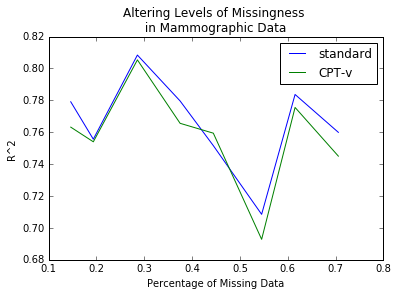

In [198]:
plt.plot(pd.DataFrame(n_sample).apply(lambda x: 120/(120.+x)).values,score_stand,label = 'standard')

plt.plot(pd.DataFrame(n_sample).apply(lambda x: 120/(120.+x)).values,score_fancy,label = 'CPT-v')
plt.legend()


plt.xlabel('Percentage of Missing Data')
plt.ylabel('R^2')
plt.title('Altering Levels of Missingness \n in Mammographic Data ')